### Installing the dependencies

In [122]:
!pip install torch numpy pandas seaborn plotly wordcloud spacy scikit-learn transformers contractions wandb sentencepiece


[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


### Step 1 : Importing the libraries

In [33]:
# ================== PyTorch Modules ==================
import torch
import torch.nn as nn
import torch.nn.utils.rnn as nn_utils
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# ================== General Purpose Libraries ==================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ================== Visualization Libraries ==================
import plotly.graph_objects as go
from wordcloud import WordCloud

# ================== Text Processing and NLP ==================
import re 
import contractions 
import spacy  #
from spacy.lang.en.stop_words import STOP_WORDS  

# ================== Model Evaluation and Data Splitting ==================
from sklearn.metrics import f1_score  
from sklearn.model_selection import train_test_split  

# ================== Hugging Face Transformers ==================
from transformers import (
    BertForSequenceClassification, 
    BertTokenizer, 
    RobertaForSequenceClassification, 
    RobertaTokenizer,
    XLNetTokenizer,XLNetForSequenceClassification,AdamW)

# ================== Downloading and Loading SpaCy Model ==================
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

print("Everything imported successfully")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 10.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Everything imported successfully



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Logging into the Weights and Bias for doing the Monitoring in Real time
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ys7233831. Use `wandb login --relogin` to force relogin


True

| **Requirement Type**         | **Count** | **Details**                                                                 |
|-------------------------------|-----------|-----------------------------------------------------------------------------|
| **Functional Requirement (F)**| 444       | Requirements specifying what the system must do.                           |
| **Non-Functional Requirements (NFRs)** | 525       | Attributes related to how the system performs rather than what it does.    |
| &nbsp;&nbsp;Availability (A)         | 31        | Uptime and fault tolerance capabilities.                                   |
| &nbsp;&nbsp;Legal (L)                | 15        | Compliance with legal and regulatory standards.                           |
| &nbsp;&nbsp;Look-and-Feel (LF)       | 49        | Aesthetic and design-related requirements.                                |
| &nbsp;&nbsp;Maintainability (MN)     | 24        | Ease of updating and maintaining the system.                              |
| &nbsp;&nbsp;Operability (O)          | 77        | Ease of operations and management by users or administrators.             |
| &nbsp;&nbsp;Performance (PE)         | 67        | Response time, throughput, and efficiency metrics.                        |
| &nbsp;&nbsp;Scalability (SC)         | 22        | Ability to scale with increased workload.                                 |
| &nbsp;&nbsp;Security (SE)            | 125       | Protection against unauthorized access, threats, and vulnerabilities.     |
| &nbsp;&nbsp;Usability (US)           | 85        | Ease of use and user experience.                                          |
| &nbsp;&nbsp;Fault Tolerance (FT)     | 18        | System’s ability to recover from faults or errors.                        |
| &nbsp;&nbsp;Portability (PO)         | 12        | Ability to transfer the system to different environments/platforms.       |

# Dataset Preperation for hierarchical classification
- For the very first stage we will do functional vs non functional classification so we will simply create dataset for that first

In [ ]:
# Reading the csv file
df = pd.read_csv("data/PROMISE_exp.csv")

# Removing the ProjectID as it is of no use for classification
df.drop(['ProjectID'],axis=1,inplace=True)

print(df.shape)

(969, 2)

In [ ]:
# Checking 5 random rows of the data
df.sample(5)

,RequirementText,_class_
904,The system shall send an order confirmation to...,F
378,System shall let administrator de-activate a c...,PE
713,Enable the admin to generate reports which con...,F
312,The product shall be able to be installed in a...,O
711,Enable a logged in user to up vote and down vo...,F


### Segregating the datasets

Now since we need to create dataseets for 2 different kinds of classificaton thus we need to make sure we are first creating the copy of the raw original dataset and fro that we will fetch 2 required datasets

In [ ]:
# Storying the copy of the original dataframe
df1 = df.copy()
df2 = df.copy()

In [ ]:
def segregate_data(df1, df2):
    """
    Segregates the data into two datasets for different levels of classification.

    This function takes two dataframes as input, df1 and df2, which are copies of the original dataset.
    It modifies df1 by replacing all non-functional categories with 'NF' label and saves it as DataV1.csv.
    It modifies df2 by removing all rows with 'F' label and saves it as DataV2.csv.

    Parameters:
    df1 (DataFrame): The first dataframe to be modified and saved.
    df2 (DataFrame): The second dataframe to be modified and saved.
    """
    # Going over the rows and replacing all the Non functional categories with NFR label
    for i in range(len(df1)):
        label = df1.at[i,'_class_']
        if label != 'F':
            df1.at[i,'_class_'] = 'NF'

    # Saving this data for very first layer of classification
    df1.to_csv("data/DataV1.csv",index=False)

    # Removing the functional requirments lable from the data df2
    df2 = df2[df2['_class_'] != 'F']
    df2.to_csv("data/DataV2.csv",index=False)

# Calling the function
segregate_data(df1,df2)


# Exploratory Data Analysis

### Analyzing Functional Vs Non functional requirments data

In [17]:
df1 = pd.read_csv("data/DataV1.csv")
df1.shape

(969, 2)

In [61]:
df1.sample(5)

,RequirementText,_class_
41,The product shall synchronize with the office ...,NF
682,The system shall provide a way to return to th...,NF
417,Promotional updates to the website should take...,NF
51,The product shall be installed by an untrained...,NF
292,Aside from server failure the software produc...,NF


In [62]:
# Create the pie chart
fig = go.Figure(data=[go.Pie(labels=df1._class_.value_counts().index, values=df1._class_.value_counts().values, hole=0.3)])

# Update layout for better visualization
fig.update_layout(
    title="Requirement Types Distribution",
    title_x=0.5,  # Center the title
    annotations=[dict(text='NFRs vs FRs', x=0.5, y=0.5, font_size=20, showarrow=False)]
)

# Show the plot
fig.show()

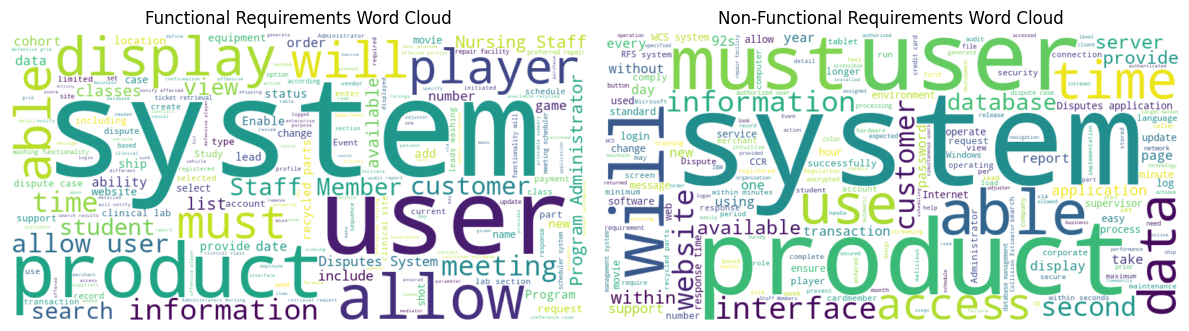

In [63]:
# Separate the data based on class
functional_text = " ".join(df1[df1['_class_'] == 'F']['RequirementText'])
non_functional_text = " ".join(df1[df1['_class_'] == 'NF']['RequirementText'])

# Generate word clouds for both categories
functional_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(functional_text)
non_functional_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(non_functional_text)

# Plotting both word clouds
plt.figure(figsize=(12, 6))

# Plot for Functional
plt.subplot(1, 2, 1)
plt.imshow(functional_wordcloud, interpolation='bilinear')
plt.title("Functional Requirements Word Cloud")
plt.axis('off')

# Plot for Non-Functional
plt.subplot(1, 2, 2)
plt.imshow(non_functional_wordcloud, interpolation='bilinear')
plt.title("Non-Functional Requirements Word Cloud")
plt.axis('off')

plt.tight_layout()
plt.show()

### Analyzing the subcategories under Non functional requirements

In [16]:
df2 = pd.read_csv("data/DataV2.csv")
df2.shape

(525, 2)

In [65]:
df2.sample(5)

,RequirementText,_class_
237,Promotional updates to the website should take...,MN
270,The washing process must use a non binding ne...,O
160,The product must be able to interface with any...,O
255,All customer information will be stored on a s...,SE
256,All credit card information will be encrypted ...,SE


In [66]:
# Create the pie chart
fig = go.Figure(data=[go.Pie(labels=df2._class_.value_counts().index, values=df2._class_.value_counts().values, hole=0.3)])

# Update layout for better visualization
fig.update_layout(
    title="Requirement Types Distribution",
    title_x=0.5,  # Center the title
    annotations=[dict(text='NFRs vs FRs', x=0.5, y=0.5, font_size=20, showarrow=False)]
)

# Show the plot
fig.show()

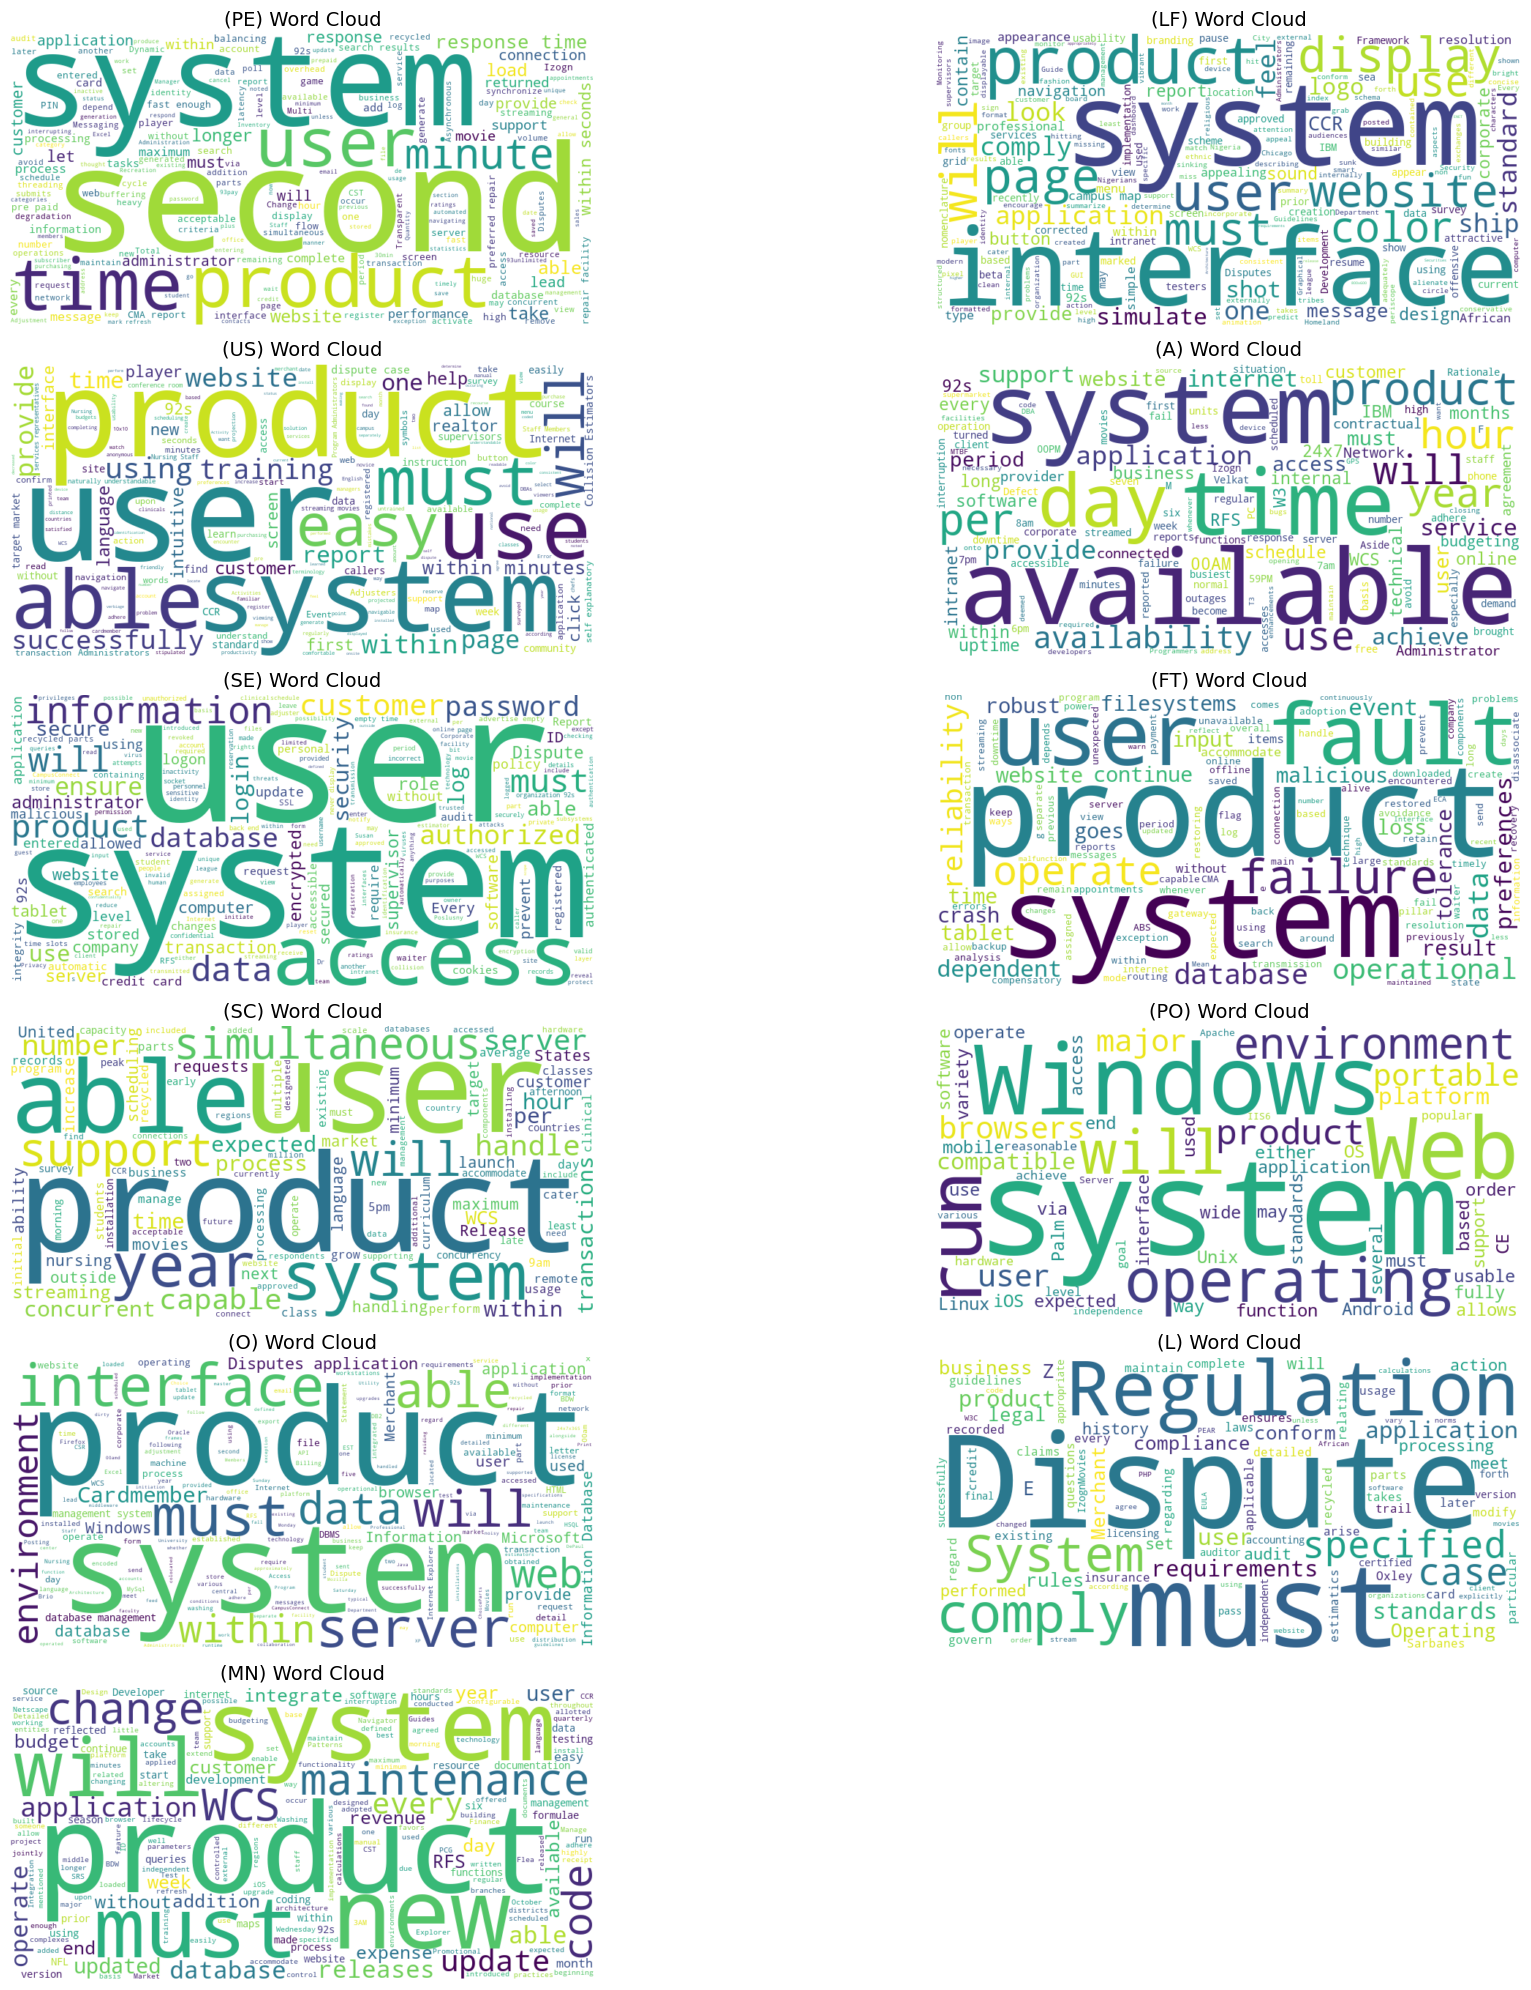

In [70]:
# Extract unique categories from the '_class_' column
categories = df2['_class_'].unique()

# Create a dictionary to store word clouds for each category
category_wordclouds = {}

# Generate word clouds for each category
for category in categories:
    category_text = " ".join(df2[df2['_class_'] == category]['RequirementText'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(category_text)
    category_wordclouds[category] = wordcloud

# Plotting all word clouds
plt.figure(figsize=(20, 20))
num_categories = len(categories)

for idx, category in enumerate(categories):
    plt.subplot((num_categories + 1) // 2, 2, idx + 1)  # Create subplots dynamically
    plt.imshow(category_wordclouds[category], interpolation='bilinear')
    plt.title(f"({category}) Word Cloud", fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Data Processing

### Creating training, test and validation splits function

In [3]:
def split_data(df, train_size):
    """
    Splits the input DataFrame into training, validation, and test sets.

    Parameters:
    - df (DataFrame): The input DataFrame to be split.
    - train_size (float): The proportion of the data to include in the train and validation sets.

    Returns:
    - train_data (DataFrame): The DataFrame containing the training data.
    - val_data (DataFrame): The DataFrame containing the validation data.
    - test_data (DataFrame): The DataFrame containing the test data.
    """
    train_val_data, test_data = train_test_split(df, train_size=train_size, random_state=19)
    train_data, val_data = train_test_split(train_val_data, train_size=train_size, random_state=19)
    return train_data, val_data, test_data

### Mapping labels to index and index to labels

In [4]:
def create_label_dicts(labels):
    """
    Creates dictionaries mapping label IDs to labels and vice versa.

    Parameters:
    - labels (list): A list of unique labels.

    Returns:
    - id2label (dict): A dictionary mapping label IDs to labels.
    - label2id (dict): A dictionary mapping labels to label IDs.
    """
    id2label = {id: label for id, label in enumerate(labels)}
    label2id = {label: id for id, label in enumerate(labels)}
    return id2label, label2id

### Text Cleaning and Processing

In [5]:
def preprocess_text(text,tokenizer):
    """
    Preprocess the input text by performing:
    - Expansion of contractions
    - Lowercasing
    - Removal of punctuation, special characters, and numbers
    - Stopword removal
    - Lemmatization
    - Bert Tokenizer

    Parameters:
    - text (str): The input text to preprocess
    - nlp: A spaCy NLP pipeline for tokenization, lemmatization, and stopword detection

    Returns:
    - str: Dictionary of input_id,token_type_id and attention_mask
    """
    # Step 1: Expand contractions (e.g., "don't" → "do not")
    text = contractions.fix(text)

    # Step 2: Lowercase the text
    text = text.lower()

    # Step 3: Remove special characters, numbers, and punctuation
    text = re.sub(r"[^a-z\s]", "", text)  # Keep only alphabetic characters and spaces

    # Step 4: Tokenize and process with spaCy
    doc = nlp(text)

    # Step 5: Process tokens - lemmatize, remove stopwords, and filter out empty tokens
    tokens = [
        token.lemma_
        for token in doc
        if not token.is_stop and token.lemma_ not in STOP_WORDS and token.lemma_.strip() != ""
    ]

    # Step 6: Join tokens back into a cleaned text string
    processed_text = " ".join(tokens)

    # Step 7 : Passing the processing text to BERT tokenizer
    return tokenizer(processed_text)


def process_label(label2id, label):
    """
    Converts a label string to its corresponding numerical ID and returns it as a PyTorch tensor.

    Parameters:
    - label2id (dict): A dictionary mapping label strings to their numerical IDs.
    - label (str): The label string to be converted.

    Returns:
    - tensor (torch.Tensor): A PyTorch tensor containing the numerical ID of the label.
    """
    numerical_label = label2id[label]
    tensor = torch.tensor(numerical_label)
    return tensor


### Centralized function for setting up configuration of different transformer models

In [6]:
def load_model_and_tokenizer(model_name, num_labels, model_type):
    """
    Load the tokenizer and model for sequence classification based on the specified model type.

    Parameters:
    - model_name (str): The name of the pre-trained model to use (e.g., "bert-base-uncased", "roberta-base", "xlnet-base-cased").
    - num_labels (int): Number of labels for the classification task.
    - model_type (str): The type of model to load (e.g., "bert", "roberta", "xlnet").

    Returns:
    - tokenizer: The tokenizer for the specified model type.
    - model: The model for sequence classification for the specified model type.
    """
    if model_type == "bert":
        # Load BERT tokenizer and model
        tokenizer = BertTokenizer.from_pretrained(model_name)
        model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    elif model_type == "roberta":
        # Load RoBERTa tokenizer and model
        tokenizer = RobertaTokenizer.from_pretrained(model_name)
        model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    elif model_type == "xlnet":
        # Load XLNet tokenizer and model
        tokenizer = XLNetTokenizer.from_pretrained(model_name)
        model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    else:
        raise ValueError("Unsupported model type. Please specify 'bert', 'roberta', or 'xlnet'.")
    
    return tokenizer, model

### Creating data loaders for training (Finetuning)

In [8]:
# TextDataset Class
class TextDataset(Dataset):
    def __init__(self, df, text_column, label_column,tokenizer,label2id,transform=None, target_transform=None):
        """
        Args:
            df (pd.DataFrame): Input DataFrame containing text and labels.
            text_column (str): Name of the column containing text data.
            label_column (str): Name of the column containing labels.
            transform (callable, optional): Transformation for text data (e.g., preprocessing).
            target_transform (callable, optional): Transformation for target labels.
        """
        self.data = df
        self.texts = self.data[text_column].tolist()
        self.labels = self.data[label_column].tolist()
        self.transform = transform
        self.target_transform = target_transform
        self.tokenizer = tokenizer
        self.label2id = label2id

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Apply text preprocessing if specified
        if self.transform:
            item = self.transform(text,self.tokenizer)

        # Apply target transformation label to id conversion
        if self.target_transform:
            tensor_label = self.target_transform(self.label2id,label)

        item['label'] = tensor_label
        return item

### Dynamic Paddding function for parallel processing

In [9]:
def collate_fn_roberta(batch):
    """
    Collate function for batching data.

    This function takes a batch of data as input, converts the lists of input_ids, attention_masks, and labels into PyTorch tensors, dynamically pads them to the same length, and stacks the labels. The padded tensors and stacked labels are then returned as a dictionary.

    Args:
        batch (list): A list of dictionaries, each containing 'input_ids', 'attention_mask', and 'label' as keys.

    Returns:
        dict: A dictionary containing the batched and padded 'input_ids', 'attention_mask', and stacked 'labels' as tensors.
    """
    # Convert lists in the batch to PyTorch tensors
    input_ids = [torch.tensor(item['input_ids']) for item in batch]
    attention_masks = [torch.tensor(item['attention_mask']) for item in batch]
    labels = [item['label'] for item in batch]  # Already a tensor in your case

    # Pad the tensors dynamically
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    # Stack the labels (already tensors)
    labels = torch.stack(labels)

    # Return batched tensors
    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks,
        'labels': labels
    }

In [10]:
def collate_fn_bert_xlnet(batch):
    """
    Collate function for batching data.

    This function takes a batch of data as input, converts the lists of input_ids, attention_masks, and labels into PyTorch tensors, dynamically pads them to the same length, and stacks the labels. The padded tensors and stacked labels are then returned as a dictionary.

    Args:
        batch (list): A list of dictionaries, each containing 'input_ids', 'attention_mask', and 'label' as keys.

    Returns:
        dict: A dictionary containing the batched and padded 'input_ids', 'attention_mask', and stacked 'labels' as tensors.
    """
    # Convert lists in the batch to PyTorch tensors
    input_ids = [torch.tensor(item['input_ids']) for item in batch]
    attention_masks = [torch.tensor(item['attention_mask']) for item in batch]
    token_type_ids = [torch.tensor(item['token_type_ids']) for item in batch]
    labels = [item['label'] for item in batch]  # Already a tensor in your case

    # Pad the tensors dynamically
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    token_type_ids = pad_sequence(token_type_ids, batch_first=True, padding_value=0)

    # Stack the labels (already tensors)
    labels = torch.stack(labels)

    # Return batched tensors
    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks,
        'token_type_ids': token_type_ids,
        'labels': labels
    }

# Model training Setup

### Defining the Early stopping to prevent overfitting

In [11]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0, save_path="artifacts/best_model_xlnet.pt"):
        self.patience = patience
        self.delta = delta
        self.save_path = save_path
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_model(model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_model(self, model):
        torch.save(model.state_dict(), self.save_path)

    def load_best_model(self, model):
        model.load_state_dict(torch.load(self.save_path))


### Defining train, test and validation loops

In [12]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device for training.")
else:
    device = torch.device("cpu")
    print("MPS device not available. Falling back to CPU.")

Using MPS device for training.


In [13]:
# Training loop with early stopping
def train_loop(dataloader, model, loss_fn, optimizer, val_loader, epoch, early_stopping=None):
    model.train()  # Set model to training mode
    size = len(dataloader.dataset)

    all_preds = []  # List to store predictions
    all_labels = []  # List to store true labels

    for batch, batch_data in enumerate(dataloader):
        # Unpack inputs for BERT
        input_ids = batch_data["input_ids"].to(device)
        attention_mask = batch_data["attention_mask"].to(device)
        labels = batch_data["labels"].to(device)

        # Compute prediction and loss
        logits = model(input_ids, attention_mask=attention_mask).logits  # Forward pass
        loss = loss_fn(logits, labels)  # Compute loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store predictions and labels for metrics computation
        all_preds.extend(logits.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Log progress and loss
        if batch % 100 == 0:
            loss_value = loss.item()
            current = batch * len(input_ids)
            print(f"loss: {loss_value:>7f}  [{current:>5d}/{size:>5d}]")
            wandb.log({
                "train_loss": loss_value,
                "epoch": epoch,
                "step": current,
            })

    # Compute F1 score
    train_f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Training F1 Score: {train_f1:.4f}")
    wandb.log({"train_f1_score": train_f1, "epoch": epoch})

    # Evaluate validation loss for early stopping
    if early_stopping:
        val_loss = evaluate_validation_loss(model, loss_fn, val_loader, epoch)
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            early_stopping.load_best_model(model)
            return True  # Stop training early
    return False

# Validation loop for loss and accuracy evaluation
def evaluate_validation_loss(model, loss_fn, val_loader, epoch):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_data in val_loader:
            input_ids = batch_data["input_ids"].to(device)
            attention_mask = batch_data["attention_mask"].to(device)
            labels = batch_data["labels"].to(device)

            logits = model(input_ids, attention_mask=attention_mask).logits
            val_loss += loss_fn(logits, labels).item()

            all_preds.extend(logits.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (logits.argmax(1) == labels).type(torch.float).sum().item()

    val_loss /= len(val_loader)
    accuracy = 100 * correct / len(val_loader.dataset)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%, F1 Score: {val_f1:.4f}")
    wandb.log({
        "validation_loss": val_loss,
        "validation_accuracy": accuracy,
        "validation_f1_score": val_f1,
        "epoch": epoch
    })

    return val_loss

# Test loop for model evaluation
def test_loop(dataloader, model, loss_fn, epoch):
    model.eval()  # Set model to evaluation mode
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_loss, correct = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_data in dataloader:
            input_ids = batch_data["input_ids"].to(device)
            attention_mask = batch_data["attention_mask"].to(device)
            labels = batch_data["labels"].to(device)

            logits = model(input_ids, attention_mask=attention_mask).logits
            test_loss += loss_fn(logits, labels).item()

            all_preds.extend(logits.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (logits.argmax(1) == labels).type(torch.float).sum().item()

    test_loss /= num_batches
    accuracy = 100 * correct / size
    test_f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Test Error: \n Accuracy: {accuracy:>0.1f}%, Avg loss: {test_loss:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")

    wandb.log({
        "test_accuracy": accuracy,
        "test_loss": test_loss,
        "test_f1_score": test_f1,
        "epoch": epoch
    })


# Initializing the Model training

### Initializing the models

In [43]:
# Define key parameters
num_labels = 2  # Number of classes (e.g., binary classification)
learning_rate = 2e-5  # Typical fine-tuning learning rate for BERT
epochs = 50  # Number of training epochs
patience = 10  # Early stopping patience
min_delta = 0.001  # Minimum improvement for early stopping


# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

In [44]:
roberta_model_name = "roberta-base"
bert_model_name = "bert-base-uncased"
xlnet_model_name = "xlnet-base-cased"

# Setting up the different models and tokenizers
bert_tokenizer, bert_model = load_model_and_tokenizer(bert_model_name, 2, "bert")
roberta_tokenizer, roberta_model = load_model_and_tokenizer(roberta_model_name, 2, "roberta")
xlnet_tokenizer, xlnet_model = load_model_and_tokenizer(xlnet_model_name, 2, "xlnet")

# Moving modesl to GPU
bert_model = bert_model.to(device)
roberta_model = roberta_model.to(device)
xlnet_model = xlnet_model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for prediction

In [20]:
# Creating train test and validation data
train_data,test_data,val_data = split_data(df1,0.8)
print(train_data.shape,val_data.shape,test_data.shape)

labels_c1 = df1['_class_'].unique().tolist()
id2label_c1, label2id_c1 = create_label_dicts(labels_c1)

(620, 2) (194, 2) (155, 2)


### BERT model training

In [26]:
# Creating the datasets and dataloaders
train_dataset = TextDataset(train_data,'RequirementText','_class_',bert_tokenizer,label2id_c1,preprocess_text,process_label)
test_dataset = TextDataset(test_data,'RequirementText','_class_',bert_tokenizer,label2id_c1,preprocess_text,process_label)
valid_dataset = TextDataset(val_data,'RequirementText','_class_',bert_tokenizer,label2id_c1,preprocess_text,process_label)

train_dataloader = DataLoader(train_dataset, batch_size=16, collate_fn=collate_fn_bert_xlnet, shuffle=True)
val_dataloader = DataLoader(valid_dataset, batch_size=16, collate_fn=collate_fn_bert_xlnet, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, collate_fn=collate_fn_bert_xlnet, shuffle=False)

In [37]:
wandb.init(
    project="Phase1_Finetuning",
    config={
        "learning_rate": 2e-5,
        "batch_size": 16,
        "epochs": 50,
        "optimizer": "AdamW",
        "model_name": "bert-base-uncased",
        "num_labels": 2,
        "pretrained_model": "bert-base-uncased",
        "train_dataset_size": len(train_dataloader) * 16,
        "test_dataset_size": len(test_dataloader) * 16,
        "validation_dataset_size": len(val_dataloader) * 16,
        "loss_fn": "CrossEntropyLoss",
        "device": device,
    },
    reinit=True
)

epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
step,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁▁▅▃▂▆▅▇██▇██▆▇▇█▇▇
test_f1_score,▁▁▅▄▃▇▆▇██▇██▇▇▇█▇▇
test_loss,▃▅▄▃▃▂▃▁▂▁▃▃▄▅▆██▅▆
train_f1_score,▁▁▃▄▄▄▆▇▇▇██████████
train_loss,█▇▆█▅▇▂▄▄▂▁▁▁▁▁▁▃▁▁▂
validation_accuracy,▁▁▄▃▂▇▅▇▇█▇██▆██████
validation_f1_score,▁▁▅▃▃▇▆██████▇██████
validation_loss,▇█▇▅▆▃▄▂▂▁▃▂▂▄▃▅▅▄▄▄
epoch,19


In [38]:
# Early stopping
optimizer = AdamW(bert_model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience=patience, delta=min_delta, save_path="artifacts/Phase1_Classification/bert.pt")

# Training loop with early stopping
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print("-" * 30)

    # Train the model
    stop_early = train_loop(train_dataloader, bert_model, loss_fn, optimizer, val_dataloader, epoch, early_stopping)

    if stop_early:
        print("Early stopping triggered. Stopping training.")
        break

    # Test the model after each epoch
    test_loop(test_dataloader, bert_model, loss_fn, epoch)

print("Training complete!")

/Users/yuvrajsingh/Desktop/AI Development/Freelance/Software_Classification/.venv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/50
------------------------------
loss: 0.659866  [    0/  620]
Training F1 Score: 0.5236
Validation Loss: 0.6807, Accuracy: 53.09%, F1 Score: 0.4750
Test Error: 
 Accuracy: 52.3%, Avg loss: 0.6950
Test F1 Score: 0.4606

Epoch 2/50
------------------------------
loss: 0.699227  [    0/  620]
Training F1 Score: 0.5321
Validation Loss: 0.6964, Accuracy: 52.06%, F1 Score: 0.3565
Test Error: 
 Accuracy: 50.3%, Avg loss: 0.7061
Test F1 Score: 0.3369

Epoch 3/50
------------------------------
loss: 0.694695  [    0/  620]
Training F1 Score: 0.5499
Validation Loss: 0.6684, Accuracy: 55.67%, F1 Score: 0.4848
Test Error: 
 Accuracy: 55.5%, Avg loss: 0.6937
Test F1 Score: 0.4714

Epoch 4/50
------------------------------
loss: 0.633568  [    0/  620]
Training F1 Score: 0.6106
Validation Loss: 0.5927, Accuracy: 68.04%, F1 Score: 0.6677
Test Error: 
 Accuracy: 65.8%, Avg loss: 0.6469
Test F1 Score: 0.6452

Epoch 5/50
------------------------------
loss: 0.556509  [    0/  620]
Training F1

/var/folders/89/f812xzx91rz99l675pn4yx3r0000gn/T/ipykernel_65951/2625115131.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(self.save_p

Early stopping triggered. Stopping training.
Training complete!


### Roberta Model training

In [39]:
# Creating the datasets and dataloaders
train_dataset = TextDataset(train_data,'RequirementText','_class_',roberta_tokenizer,label2id_c1,preprocess_text,process_label)
test_dataset = TextDataset(test_data,'RequirementText','_class_',roberta_tokenizer,label2id_c1,preprocess_text,process_label)
valid_dataset = TextDataset(val_data,'RequirementText','_class_',roberta_tokenizer,label2id_c1,preprocess_text,process_label)

train_dataloader = DataLoader(train_dataset, batch_size=16, collate_fn=collate_fn_roberta, shuffle=True)
val_dataloader = DataLoader(valid_dataset, batch_size=16, collate_fn=collate_fn_roberta, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, collate_fn=collate_fn_roberta, shuffle=False)

In [45]:
wandb.init(
    project="Phase1_Finetuning",
    config={
        "learning_rate": 2e-5,
        "batch_size": 16,
        "epochs": 50,
        "optimizer": "AdamW",
        "model_name": "roberta-base-uncased",
        "num_labels": 2,
        "pretrained_model": "roberta-base-uncased",
        "train_dataset_size": len(train_dataloader) * 16,
        "test_dataset_size": len(test_dataloader) * 16,
        "validation_dataset_size": len(val_dataloader) * 16,
        "loss_fn": "CrossEntropyLoss",
        "device": device,
    },
    reinit=True
)

epoch,▁▁▁▁▂▂▂▂▄▄▄▄▅▅▅▅▇▇▇▇███
step,▁▁▁▁▁▁
test_accuracy,▁▁▁▁▁
test_f1_score,▁▁▁▁▁
test_loss,▁▁▁▁▁
train_f1_score,▄▃▁▅▃█
train_loss,▅▄█▁▁▃
validation_accuracy,▁▁▁▁▁▁
validation_f1_score,▁▁▁▁▁▁
validation_loss,▁▁▁▁▁▁
epoch,5


In [42]:
# Early stopping
optimizer = AdamW(bert_model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience=patience, delta=min_delta, save_path="artifacts/Phase1_Classification/roberta.pt")

# Training loop with early stopping
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print("-" * 30)

    # Train the model
    stop_early = train_loop(train_dataloader, roberta_model, loss_fn, optimizer, val_dataloader, epoch, early_stopping)

    if stop_early:
        print("Early stopping triggered. Stopping training.")
        break

    # Test the model after each epoch
    test_loop(test_dataloader, roberta_model, loss_fn, epoch)

print("Training complete!")

/Users/yuvrajsingh/Desktop/AI Development/Freelance/Software_Classification/.venv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/50
------------------------------
loss: 0.697270  [    0/  620]
Training F1 Score: 0.5036
Validation Loss: 0.6930, Accuracy: 51.55%, F1 Score: 0.3630
Test Error: 
 Accuracy: 51.0%, Avg loss: 0.6930
Test F1 Score: 0.3618

Epoch 2/50
------------------------------
loss: 0.693734  [    0/  620]
Training F1 Score: 0.4897
Validation Loss: 0.6930, Accuracy: 51.55%, F1 Score: 0.3630
Test Error: 
 Accuracy: 51.0%, Avg loss: 0.6930
Test F1 Score: 0.3618

Epoch 3/50
------------------------------
loss: 0.707910  [    0/  620]
Training F1 Score: 0.4750
Validation Loss: 0.6930, Accuracy: 51.55%, F1 Score: 0.3630
Test Error: 
 Accuracy: 51.0%, Avg loss: 0.6930
Test F1 Score: 0.3618

Epoch 4/50
------------------------------
loss: 0.685691  [    0/  620]
Training F1 Score: 0.5088
Validation Loss: 0.6930, Accuracy: 51.55%, F1 Score: 0.3630
Test Error: 
 Accuracy: 51.0%, Avg loss: 0.6930
Test F1 Score: 0.3618

Epoch 5/50
------------------------------
loss: 0.685140  [    0/  620]
Training F1

wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


/var/folders/89/f812xzx91rz99l675pn4yx3r0000gn/T/ipykernel_65951/2625115131.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(self.save_p

Early stopping triggered. Stopping training.
Training complete!


### XLnet Model training

In [28]:
# Creating the datasets and dataloaders
train_dataset = TextDataset(train_data,'RequirementText','_class_',xlnet_tokenizer,label2id_c1,preprocess_text,process_label)
test_dataset = TextDataset(test_data,'RequirementText','_class_',xlnet_tokenizer,label2id_c1,preprocess_text,process_label)
valid_dataset = TextDataset(val_data,'RequirementText','_class_',xlnet_tokenizer,label2id_c1,preprocess_text,process_label)

train_dataloader = DataLoader(train_dataset, batch_size=16, collate_fn=collate_fn_bert_xlnet, shuffle=True)
val_dataloader = DataLoader(valid_dataset, batch_size=16, collate_fn=collate_fn_bert_xlnet, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, collate_fn=collate_fn_bert_xlnet, shuffle=False)

In [18]:
wandb.init(
    project="Phase1_Finetuning",
    config={
        "learning_rate": 2e-5,
        "batch_size": 16,
        "epochs": 50,
        "optimizer": "AdamW",
        "model_name": "xlnet-base-uncased",
        "num_labels": 2,
        "pretrained_model": "xlnet-base-uncased",
        "train_dataset_size": len(train_dataloader) * 16,
        "test_dataset_size": len(test_dataloader) * 16,
        "validation_dataset_size": len(val_dataloader) * 16,
        "loss_fn": "CrossEntropyLoss",
        "device": device,
    },
    reinit=True
)

In [23]:
# Early stopping
optimizer = AdamW(bert_model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience=patience, delta=min_delta, save_path="artifacts/Phase1_Classification/xlnet.pt")

# Training loop with early stopping
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print("-" * 30)

    # Train the model
    stop_early = train_loop(train_dataloader, xlnet_model, loss_fn, optimizer, val_dataloader, epoch, early_stopping)

    if stop_early:
        print("Early stopping triggered. Stopping training.")
        break

    # Test the model after each epoch
    test_loop(test_dataloader, xlnet_model, loss_fn, epoch)

print("Training complete!")

Epoch 1/50

------------------------------

loss: 0.652697  [    0/  620]

Training F1 Score: 0.5536

Validation Loss: 0.5819, Accuracy: 64.52%, F1 Score: 0.6395

Test Error: 
 Accuracy: 72.7%, Avg loss: 0.5427

Test F1 Score: 0.7215

Epoch 2/50

------------------------------

loss: 0.581795  [    0/  620]

Training F1 Score: 0.7431

Validation Loss: 0.5888, Accuracy: 72.26%, F1 Score: 0.7063

Test Error: 
 Accuracy: 78.9%, Avg loss: 0.4432

Test F1 Score: 0.7817

Epoch 3/50

------------------------------

loss: 0.368193  [    0/  620]

Training F1 Score: 0.8326

Validation Loss: 0.5601, Accuracy: 77.42%, F1 Score: 0.7674

Test Error: 
 Accuracy: 83.5%, Avg loss: 0.3881

Test F1 Score: 0.8330

Epoch 4/50

------------------------------

loss: 0.443136  [    0/  620]

Training F1 Score: 0.9082

Validation Loss: 0.5833, Accuracy: 82.58%, F1 Score: 0.8255

Test Error: 
 Accuracy: 91.2%, Avg loss: 0.2460

Test F1 Score: 0.9124

Epoch 5/50

------------------------------

loss: 0.080322  [    0/  620]

Training F1 Score: 0.9306

Validation Loss: 0.5634, Accuracy: 80.00%, F1 Score: 0.7971

Test Error: 
 Accuracy: 85.6%, Avg loss: 0.3544

Test F1 Score: 0.8552

Epoch 6/50

------------------------------

loss: 0.199020  [    0/  620]

Training F1 Score: 0.9629

Validation Loss: 0.6112, Accuracy: 83.87%, F1 Score: 0.8380

Test Error: 
 Accuracy: 89.2%, Avg loss: 0.3201

Test F1 Score: 0.8917

Epoch 7/50

------------------------------

loss: 0.119936  [    0/  620]

Training F1 Score: 0.9678

Validation Loss: 0.7373, Accuracy: 85.16%, F1 Score: 0.8516

Test Error: 
 Accuracy: 90.2%, Avg loss: 0.3598

Test F1 Score: 0.9020

Epoch 8/50

------------------------------

loss: 0.007016  [    0/  620]

Training F1 Score: 0.9758

Validation Loss: 0.4739, Accuracy: 83.23%, F1 Score: 0.8322

Test Error: 
 Accuracy: 88.7%, Avg loss: 0.2625

Test F1 Score: 0.8865

Epoch 9/50

------------------------------

loss: 0.019670  [    0/  620]

Training F1 Score: 0.9887

Validation Loss: 0.7911, Accuracy: 82.58%, F1 Score: 0.8255

Test Error: 
 Accuracy: 86.6%, Avg loss: 0.4475

Test F1 Score: 0.8659

Epoch 10/50

------------------------------

loss: 0.083339  [    0/  620]

Training F1 Score: 0.9839

Validation Loss: 0.8921, Accuracy: 83.23%, F1 Score: 0.8316

Test Error: 
 Accuracy: 90.7%, Avg loss: 0.4315

Test F1 Score: 0.9072

Epoch 11/50

------------------------------

loss: 0.001440  [    0/  620]

Training F1 Score: 0.9806

Validation Loss: 0.8089, Accuracy: 83.23%, F1 Score: 0.8313

Test Error: 
 Accuracy: 89.2%, Avg loss: 0.3718

Test F1 Score: 0.8918

Epoch 12/50

------------------------------

loss: 0.002067  [    0/  620]

Training F1 Score: 0.9758

Validation Loss: 0.7705, Accuracy: 85.81%, F1 Score: 0.8580

Test Error: 
 Accuracy: 89.7%, Avg loss: 0.4014

Test F1 Score: 0.8970

Epoch 13/50

------------------------------

loss: 0.015231  [    0/  620]

Training F1 Score: 0.9887

Validation Loss: 0.8637, Accuracy: 81.29%, F1 Score: 0.8117

Test Error: 
 Accuracy: 89.2%, Avg loss: 0.4245

Test F1 Score: 0.8917

Epoch 14/50

------------------------------

loss: 0.001320  [    0/  620]

Training F1 Score: 0.9984

Validation Loss: 0.9420, Accuracy: 82.58%, F1 Score: 0.8250

Test Error: 
 Accuracy: 90.2%, Avg loss: 0.4116

Test F1 Score: 0.9021

Epoch 15/50

------------------------------

loss: 0.000519  [    0/  620]

Training F1 Score: 0.9952

Validation Loss: 1.0861, Accuracy: 80.65%, F1 Score: 0.8045

Test Error: 
 Accuracy: 86.1%, Avg loss: 0.6822

Test F1 Score: 0.8604

Epoch 16/50

------------------------------

loss: 0.007279  [    0/  620]

Training F1 Score: 0.9952

Validation Loss: 0.8375, Accuracy: 83.23%, F1 Score: 0.8312

Test Error: 
 Accuracy: 90.7%, Avg loss: 0.4688

Test F1 Score: 0.9066

Epoch 17/50

------------------------------

loss: 0.005397  [    0/  620]

Training F1 Score: 0.9855

Validation Loss: 0.8761, Accuracy: 80.00%, F1 Score: 0.7977

Test Error: 
 Accuracy: 87.6%, Avg loss: 0.5006

Test F1 Score: 0.8755

Epoch 18/50

------------------------------

loss: 0.164214  [    0/  620]

Training F1 Score: 0.9807

Validation Loss: 0.7422, Accuracy: 87.74%, F1 Score: 0.8774

Early stopping triggered

/var/folders/89/f812xzx91rz99l675pn4yx3r0000gn/T/ipykernel_61926/2625115131.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(self.save_p

Early stopping triggered. Stopping training.

Training complete!

### Evaluation

In [119]:
import torch
from sklearn.metrics import f1_score

# Function to evaluate the model on test or validation set
def evaluate_model(dataloader, model, loss_fn, device):
    model.eval()  # Set model to evaluation mode

    test_loss = 0.0
    correct = 0
    all_preds = []  # List to store predicted labels
    all_labels = []  # List to store true labels

    with torch.no_grad():  # Disable gradient calculation
        for batch_data in dataloader:
            # Get input data and labels
            input_ids = batch_data["input_ids"].to(device)
            attention_mask = batch_data["attention_mask"].to(device)
            labels = batch_data["labels"].to(device)

            # Forward pass to get logits (predictions)
            logits = model(input_ids, attention_mask=attention_mask).logits

            # Calculate loss
            loss = loss_fn(logits, labels)
            test_loss += loss.item()

            # Get the predicted class (the index with the maximum logit value)
            preds = logits.argmax(1)

            # Store predictions and labels for F1 score calculation
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Count correct predictions for accuracy
            correct += (preds == labels).type(torch.float).sum().item()

    # Calculate metrics: average loss, accuracy, and F1 score
    avg_loss = test_loss / len(dataloader)
    accuracy = 100 * correct / len(dataloader.dataset)
    f1 = f1_score(all_labels, all_preds, average='weighted')  # Using weighted average for multi-class

    # Print the metrics
    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, F1 Score: {f1:.4f}")

    return avg_loss, accuracy, f1

# Usage with the best model
model.load_state_dict(torch.load("artifacts/best_model_roberta.pt"))
model = model.to(device)

# Example usage for the test set
test_loss, test_accuracy, test_f1 = evaluate_model(test_dataloader, model, loss_fn, device)

# Optionally log to WandB or other tools
wandb.log({
    "test_loss": test_loss,
    "test_accuracy": test_accuracy,
    "test_f1_score": test_f1
})


/var/folders/89/f812xzx91rz99l675pn4yx3r0000gn/T/ipykernel_57904/82875747.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("artifacts/be

Test Loss: 0.3183, Accuracy: 88.66%, F1 Score: 0.8859

### Creating train,test and validations sets

In [30]:
train_val_data,test_data = train_test_split(df2,train_size=0.8,random_state=19)
train_data,val_data = train_test_split(train_val_data,train_size=0.8,random_state=19)

print(f"Training date shape : {train_data.shape}")
print(f"Test date shape : {test_data.shape}")
print(f"Validation date shape : {val_data.shape}")

Training date shape : (336, 2)

Test date shape : (105, 2)

Validation date shape : (84, 2)

In [32]:
# Calling the create label function
labels = df2['_class_'].unique().tolist()
id2label, label2id = create_label_dicts(labels)

In [50]:
# Creating the datasets and dataloaders
train_dataset = TextDataset(train_data,'RequirementText','_class_',tokenizer,label2id,preprocess_text,process_label)
test_dataset = TextDataset(test_data,'RequirementText','_class_',tokenizer,label2id,preprocess_text,process_label)
valid_dataset = TextDataset(val_data,'RequirementText','_class_',tokenizer,label2id,preprocess_text,process_label)

# Creatint the data loaders for parallel training
train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
    collate_fn=collate_fn,
    shuffle=True
)

val_dataloader = DataLoader(
    valid_dataset,
    batch_size=16,
    collate_fn=collate_fn,
    shuffle=False
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=16,
    collate_fn=collate_fn,
    shuffle=False
)

In [55]:
# Initialize WandB to track the experiment
wandb.init(
    project="Phase2_Software_Classification",
    config={
        "learning_rate": 2e-5,  # Typical learning rate for BERT fine-tuning
        "batch_size": 16,       # Batch size for the data loader
        "epochs": 10,           # Total number of epochs to train
        "optimizer": "AdamW",   # Optimizer being used for BERT
        "model_name": "Roberta-base-uncased",   # Model architecture name
        "num_labels": len(labels),        # Number of classes (binary classification)
        "pretrained_model": "Roberta-base-uncased",  # Pre-trained BERT model used
        "train_dataset_size": len(train_dataloader) * 16,  # Training dataset size
        "test_dataset_size": len(test_dataloader) * 16,    # Test dataset size
        "validation_dataset_size": len(val_dataloader) * 16,  # Validation dataset size
        "loss_fn": "CrossEntropyLoss",  # Loss function
        "device": device,       # Device being used (cuda or cpu)
    },
    reinit=True
)

epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
step,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁▄▅▆▇▇▇██▇██████████████
test_f1_score,▁▄▅▅▆▆▇██▇██▇███████████
test_loss,█▇▅▄▃▂▂▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃
train_f1_score,▁▂▃▅▅▇▇▇█████████████████
train_loss,█▇▅▅▄▃▄▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▃▅▅▇▆▇██▇▇██▇███████████
validation_f1_score,▁▃▅▅▇▆▇██▇███████████████
validation_loss,█▇▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,24


In [57]:
# Define key parameters
num_labels = len(labels)  # Number of classes (e.g., binary classification)
learning_rate = 2e-5  # Typical fine-tuning learning rate for BERT
epochs = 50  # Number of training epochs
patience = 10  # Early stopping patience
min_delta = 0.001  # Minimum improvement for early stopping


# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Early stopping
early_stopping = EarlyStopping(patience=patience, delta=min_delta, save_path="artifacts/best_model_xlnet.pt")

# Training loop with early stopping
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print("-" * 30)

    # Train the model
    stop_early = train_loop(train_dataloader, model, loss_fn, optimizer, val_dataloader, epoch, early_stopping)

    if stop_early:
        print("Early stopping triggered. Stopping training.")
        break

    # Test the model after each epoch
    test_loop(test_dataloader, model, loss_fn, epoch)

print("Training complete!")

Epoch 1/50

------------------------------

loss: 2.431485  [    0/  336]

Training F1 Score: 0.1350

Validation Loss: 2.1135, Accuracy: 29.76%, F1 Score: 0.1365

Test Error: 
 Accuracy: 21.0%, Avg loss: 2.3521

Test F1 Score: 0.0726

Epoch 2/50

------------------------------

loss: 2.215650  [    0/  336]

Training F1 Score: 0.2200

Validation Loss: 1.8082, Accuracy: 46.43%, F1 Score: 0.3714

Test Error: 
 Accuracy: 39.0%, Avg loss: 2.1008

Test F1 Score: 0.3096

Epoch 3/50

------------------------------

loss: 1.833441  [    0/  336]

Training F1 Score: 0.4726

Validation Loss: 1.3753, Accuracy: 57.14%, F1 Score: 0.5064

Test Error: 
 Accuracy: 48.6%, Avg loss: 1.7547

Test F1 Score: 0.4081

Epoch 4/50

------------------------------

loss: 1.023390  [    0/  336]

Training F1 Score: 0.6216

Validation Loss: 1.0951, Accuracy: 64.29%, F1 Score: 0.5946

Test Error: 
 Accuracy: 50.5%, Avg loss: 1.5471

Test F1 Score: 0.4333

Epoch 5/50

------------------------------

loss: 1.005012  [    0/  336]

Training F1 Score: 0.7795

Validation Loss: 0.9202, Accuracy: 67.86%, F1 Score: 0.6460

Test Error: 
 Accuracy: 58.1%, Avg loss: 1.3693

Test F1 Score: 0.5221

Epoch 6/50

------------------------------

loss: 0.821634  [    0/  336]

Training F1 Score: 0.8745

Validation Loss: 0.9402, Accuracy: 67.86%, F1 Score: 0.6566

Test Error: 
 Accuracy: 56.2%, Avg loss: 1.4075

Test F1 Score: 0.5125

Epoch 7/50

------------------------------

loss: 0.441417  [    0/  336]

Training F1 Score: 0.9167

Validation Loss: 0.7651, Accuracy: 75.00%, F1 Score: 0.7430

Test Error: 
 Accuracy: 60.0%, Avg loss: 1.2684

Test F1 Score: 0.5583

Epoch 8/50

------------------------------

loss: 0.257127  [    0/  336]

Training F1 Score: 0.9427

Validation Loss: 0.7405, Accuracy: 70.24%, F1 Score: 0.7053

Test Error: 
 Accuracy: 64.8%, Avg loss: 1.2832

Test F1 Score: 0.6113

Epoch 9/50

------------------------------

loss: 0.139887  [    0/  336]

Training F1 Score: 0.9848

Validation Loss: 0.7066, Accuracy: 72.62%, F1 Score: 0.7269

Test Error: 
 Accuracy: 63.8%, Avg loss: 1.3461

Test F1 Score: 0.5944

Epoch 10/50

------------------------------

loss: 0.074150  [    0/  336]

Training F1 Score: 0.9940

Validation Loss: 0.7225, Accuracy: 73.81%, F1 Score: 0.7477

Test Error: 
 Accuracy: 66.7%, Avg loss: 1.2994

Test F1 Score: 0.6649

Epoch 11/50

------------------------------

loss: 0.119826  [    0/  336]

Training F1 Score: 0.9941

Validation Loss: 0.7286, Accuracy: 76.19%, F1 Score: 0.7545

Test Error: 
 Accuracy: 65.7%, Avg loss: 1.4537

Test F1 Score: 0.6282

Epoch 12/50

------------------------------

loss: 0.062154  [    0/  336]

Training F1 Score: 0.9970

Validation Loss: 0.8193, Accuracy: 73.81%, F1 Score: 0.7373

Test Error: 
 Accuracy: 64.8%, Avg loss: 1.4059

Test F1 Score: 0.6298

Epoch 13/50

------------------------------

loss: 0.061412  [    0/  336]

Training F1 Score: 1.0000

Validation Loss: 0.7468, Accuracy: 76.19%, F1 Score: 0.7666

Test Error: 
 Accuracy: 65.7%, Avg loss: 1.4862

Test F1 Score: 0.6394

Epoch 14/50

------------------------------

loss: 0.048494  [    0/  336]

Training F1 Score: 1.0000

Validation Loss: 0.7153, Accuracy: 77.38%, F1 Score: 0.7661

Test Error: 
 Accuracy: 66.7%, Avg loss: 1.4469

Test F1 Score: 0.6478

Epoch 15/50

------------------------------

loss: 0.038171  [    0/  336]

Training F1 Score: 1.0000

Validation Loss: 0.7848, Accuracy: 78.57%, F1 Score: 0.7810

Test Error: 
 Accuracy: 66.7%, Avg loss: 1.5298

Test F1 Score: 0.6473

Epoch 16/50

------------------------------

loss: 0.026068  [    0/  336]

Training F1 Score: 1.0000

Validation Loss: 0.7586, Accuracy: 75.00%, F1 Score: 0.7532

Test Error: 
 Accuracy: 65.7%, Avg loss: 1.5650

Test F1 Score: 0.6428

Epoch 17/50

------------------------------

loss: 0.028691  [    0/  336]

Training F1 Score: 0.9970

Validation Loss: 0.7392, Accuracy: 77.38%, F1 Score: 0.7766

Test Error: 
 Accuracy: 65.7%, Avg loss: 1.5994

Test F1 Score: 0.6434

Epoch 18/50

------------------------------

loss: 0.029898  [    0/  336]

Training F1 Score: 0.9970

Validation Loss: 0.7892, Accuracy: 80.95%, F1 Score: 0.7937

Test Error: 
 Accuracy: 68.6%, Avg loss: 1.5567

Test F1 Score: 0.6610

Epoch 19/50

------------------------------

loss: 0.017752  [    0/  336]

Training F1 Score: 0.9881

Validation Loss: 0.9354, Accuracy: 72.62%, F1 Score: 0.7260

Early stopping triggered

/var/folders/89/f812xzx91rz99l675pn4yx3r0000gn/T/ipykernel_61926/2625115131.py:25: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Early stopping triggered. Stopping training.

Training complete!

# Performance Results and Evaluation

# Inference